### Import

In [1]:
import sys; sys.path.insert(0, '..')
import os
import pandas as pd
import numpy as np
import seaborn as sns
from matplotlib import pyplot as plt
from tabulate import tabulate
from df_utils import df_wrapper, get_timestamp_and_pose, POSE_MAP, combine_dataframes
from dataclasses import dataclass
from sklearn.pipeline import make_pipeline
from sklearn.preprocessing import StandardScaler
from sklearn.neighbors import KNeighborsClassifier
from sklearn.neural_network import MLPClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import train_test_split
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import MinMaxScaler
from sklearn.neighbors import KNeighborsClassifier
from sklearn.model_selection import GridSearchCV

### Define data

In [2]:
@dataclass
class training_class:
    csv_file: str
    annot_file: str

@dataclass
class testing_class:
    csv_file: str
    annot_file: str

training_files = {
    "Martin": training_class("../../data/train_data/martin_train_3_030221.csv", 
                            "../../data/annotation/training/martin_train_3_030221.txt"),
    "Simon": training_class("../../data/train_data/simon_train_3_080221.csv",
                            "../../data/annotation/training/simon_train_3_080221.txt"),
    "Jonas": training_class("../../data/train_data/jonas_train_3_080221.csv",
                            "../../data/annotation/training/jonas_train_3_080221.txt"),
    "Elise": training_class("../../data/train_data/elise_train_3_090221.csv",
                            "../../data/annotation/training/elise_train_3_090221.txt"),
    "Emanuel": training_class("../../data/train_data/emanuel_train_3_110221.csv",
                            "../../data/annotation/training/emanuel_train_3_110221.txt"),
    "Xiaomeng": training_class("../../data/train_data/xiaomeng_train_3_110221.csv",
                            "../../data/annotation/training/xiaomeng_train_3_110221.txt"),
}
"""
testing_file = testing_class("../../data/test_data/martin_test_3_040221.csv",
                             "../../data/annotation/testing/martin_test_3_040221.txt")
"""
testing_file = testing_class("../../data/test_data/emanuel_test_3_110221.csv",
                             "../../data/annotation/testing/emanuel_test_3_110221.txt")

AMOUNT_OF_SENSORS = 3

### Datapreparation

In [3]:
knn_train = []
for key in training_files:
    elem = df_wrapper(training_files[key].csv_file)
    elem.concat_sensor_data(AMOUNT_OF_SENSORS)
    stamped_poses = get_timestamp_and_pose(training_files[key].annot_file, POSE_MAP)
    elem.align_poses(stamped_poses)
    knn_train.append(elem)

y_train = pd.concat([x.df['Pose'] for x in knn_train])

knn_test = df_wrapper(testing_file.csv_file)
knn_test.concat_sensor_data(AMOUNT_OF_SENSORS)
test_stamped_poses = get_timestamp_and_pose(testing_file.annot_file, POSE_MAP)
knn_test.align_poses(test_stamped_poses)
y_test = knn_test.df["Pose"]
y_test.index = [i for i in range(len(y_test))]

../df_utils.py:36: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self.df_arr[i][" TimeStamp (s)"] = self.df_arr[i][" TimeStamp (s)"] - \
../df_utils.py:36: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self.df_arr[i][" TimeStamp (s)"] = self.df_arr[i][" TimeStamp (s)"] - \
../df_utils.py:36: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas

### Visualisation

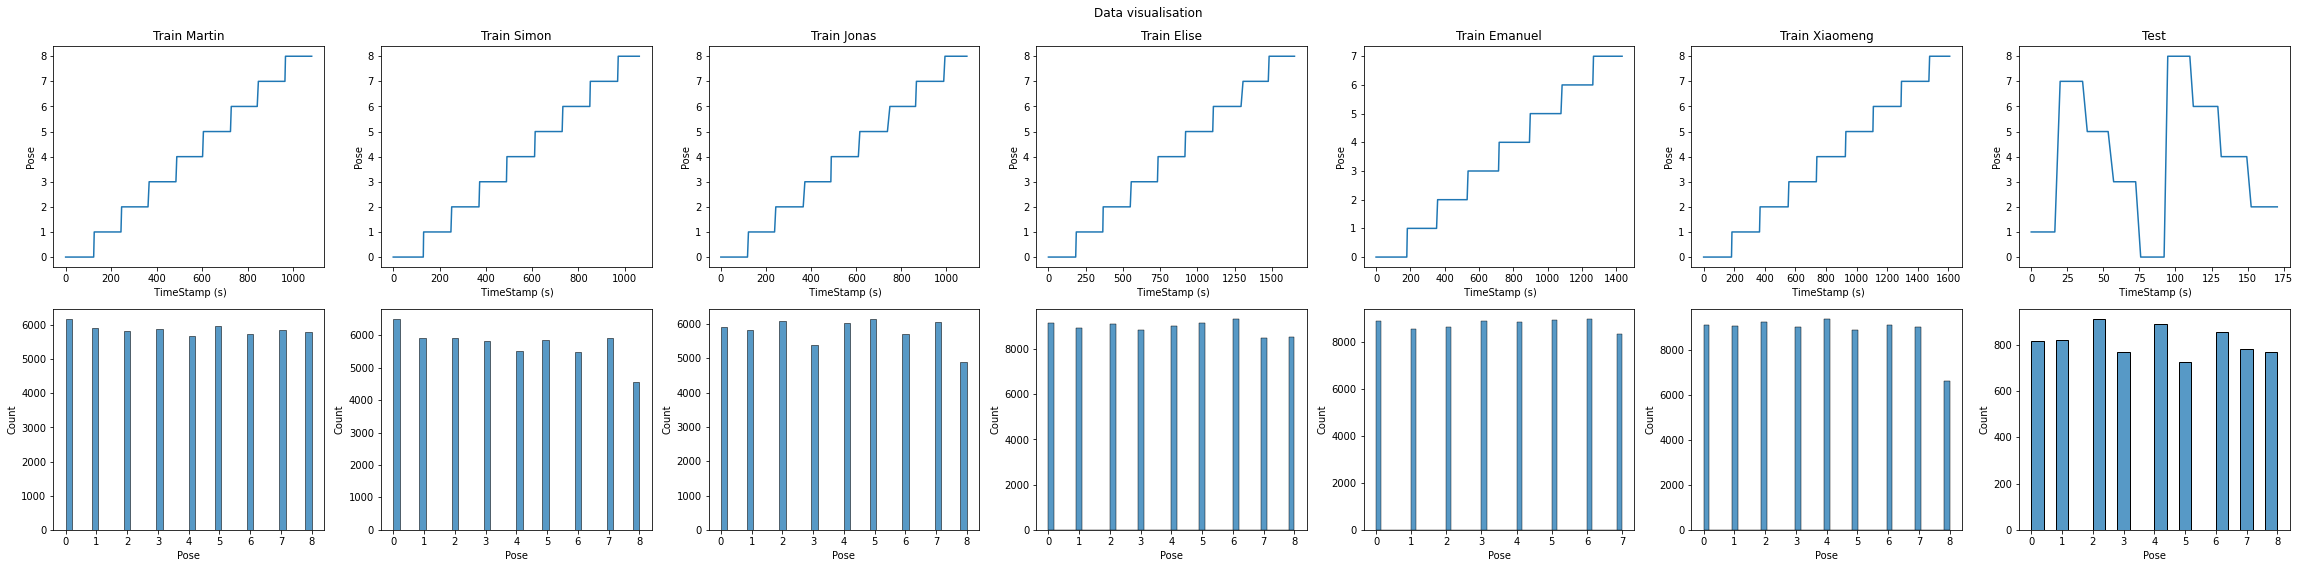

In [4]:
cols = []
height=8
width=(height/1.5)*len(knn_train)
fig, axes = plt.subplots(2, len(knn_train)+1, figsize=(width, height))
fig.suptitle('Data visualisation')
for i in range(len(knn_train)):
    sns.lineplot(ax=axes[0, i], data=knn_train[i].df, x=" TimeStamp (s)", y='Pose')
    sns.histplot(ax=axes[1, i], data=knn_train[i].df["Pose"])
    cols.append('Train')    
for i, key in enumerate(training_files):
    cols[i] += f' {key}'
sns.lineplot(ax=axes[0, len(knn_train)], data=knn_test.df, x=" TimeStamp (s)", y='Pose')
sns.histplot(ax=axes[1, len(knn_train)], data=y_test)
cols.append('Test')
for ax, col in zip(axes[0], cols):
    ax.set_title(col)
fig.tight_layout()
plt.show()

### Adjust dataframes

In [5]:
x_train = combine_dataframes([x.df.drop([' TimeStamp (s)', 'Pose'],axis=1) for x in knn_train])
x_test = knn_test.df.drop([' TimeStamp (s)', 'Pose'], axis=1) 

print(x_train.shape)
print(y_train.shape)
print(x_test.shape)
print(y_test.shape)

(386320, 48)
(386320,)
(7329, 48)
(7329,)


In [6]:
#n_estimators_lst = [i for i in range(1, 200)]
#parameters = {'n_estimators':n_estimators_lst} 
#rfc = RandomForestClassifier(random_state=69)
#clf = GridSearchCV(rfc, parameters, n_jobs=-1)
#clf.fit(x_train, y_train)

pipe = make_pipeline(RandomForestClassifier(n_estimators=105, random_state=69))
pipe.fit(x_train,y_train)
predictions = pipe.predict(x_test)

'\naccuracy_arr = []\nfor i in range(100,200):\n    pipe = make_pipeline(RandomForestClassifier(n_estimators=105, random_state=69))\n    pipe.fit(x_train,y_train)\n    predictions = pipe.predict(x_test)\n\n    number_of_corrects = 0\n    for num in range(len(predictions)):\n        if(predictions[num] == y_test.iloc[num]):\n            number_of_corrects += 1\n\n    print("number of correct: {}".format(number_of_corrects))\n    print("number of guesses: {}".format(len(predictions)))\n    print("% correct: {}".format(number_of_corrects / len(predictions) * 100))\n    accuracy_arr.append((number_of_corrects / len(predictions) * 100))\n\nprint("Argmax: ",np.argmax(accuracy_arr))\n'

<AxesSubplot:xlabel='x', ylabel='y'>

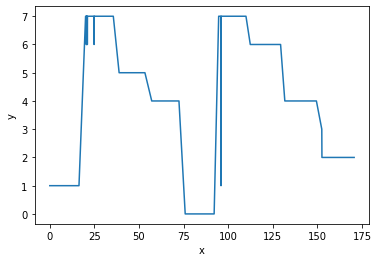

In [7]:
df_predict = pd.DataFrame({'x': knn_test.df[' TimeStamp (s)'],'y':predictions})
sns.lineplot(data=df_predict,x='x',y='y')

[[815   0   0   0   0   0   0   0   0]
 [  0 819   0   0   0   0   0   0   0]
 [  0   0 907   2   0   0   0   0   0]
 [  0   0   0   0 767   0   0   0   0]
 [  0   0   0   0 889   0   0   0   0]
 [  0   0   0   0   0 727   0   0   0]
 [  0   0   0   0   0   0 853   0   0]
 [  0   0   0   0   0   0  16 765   0]
 [  0   5   0   0   0   0   0 764   0]]
              precision    recall  f1-score   support

           0       1.00      1.00      1.00       815
           1       0.99      1.00      1.00       819
           2       1.00      1.00      1.00       909
           3       0.00      0.00      0.00       767
           4       0.54      1.00      0.70       889
           5       1.00      1.00      1.00       727
           6       0.98      1.00      0.99       853
           7       0.50      0.98      0.66       781
           8       1.00      0.00      0.00       769

    accuracy                           0.79      7329
   macro avg       0.78      0.78      0.71      732

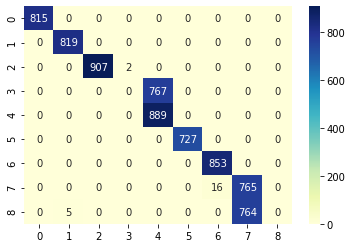

In [8]:
from sklearn.metrics import confusion_matrix
from sklearn.metrics import classification_report
print(confusion_matrix(y_test, predictions))
print(classification_report(y_test, predictions, zero_division=True))

sns.heatmap(confusion_matrix(y_test, predictions),
            cmap="YlGnBu", annot=True, fmt="d")

number_of_corrects = 0
for num in range(len(predictions)):
    if(predictions[num] == y_test.iloc[num]):
        number_of_corrects += 1

print("number of correct: {}".format(number_of_corrects))
print("number of guesses: {}".format(len(predictions)))
print("% correct: {}".format(number_of_corrects / len(predictions) * 100))

In [9]:
number_of_corrects = 0
for num in range(len(predictions)):
    if(predictions[num] == y_test.iloc[num]):
        number_of_corrects += 1


print("number of correct: {}".format(number_of_corrects))
print("number of guesses: {}".format(len(predictions)))
print("% correct: {}".format(number_of_corrects/len(predictions)*100))

number of correct: 5775
number of guesses: 7329
% correct: 78.79656160458453


<a style='text-decoration:none;line-height:16px;display:flex;color:#5B5B62;padding:10px;justify-content:end;' href='https://deepnote.com?utm_source=created-in-deepnote-cell&projectId=59d486bc-e14d-4632-9064-12272fc72d11' target="_blank">
 </img>
Created in <span style='font-weight:600;margin-left:4px;'>Deepnote</span></a>